# Bond Survival Curve

In [1]:
import sys
import datetime
import matplotlib.pyplot as plt
from finpricing.model import BondCurveAnalyticsHelper, BondCurveSolver, cds_market_spreads
from finpricing.market import SurvivalCurveStep, SurvivalCurveNelsonSiegel
from finpricing.utils import Date, prettyTableByColumn
import finpricing.utils.instaplot as isplt
# this assumes this notebook is running in the /docs folder and the data is in the /tests folder
sys.path.append(r'../tests')
from testing_utils.read_data import get_sample_bonds_portfolio, get_sample_discount_curve

## Read Reference and Market Data

We pick 10 bonds from the same issuer on 2023-10-09, and fix all the market data accordingly.

In [2]:
bonds, dirty_prices, balance = get_sample_bonds_portfolio(include_balance=True)
discount_curve      = get_sample_discount_curve()
valuation_date      = datetime.date(2023, 10, 9)
settlement_date     = datetime.date(2023, 10, 11)

In [3]:
prettyTableByColumn(
    {
        'Bond': bonds,
        'Dirty Price': dirty_prices
    },
    align='lr'
)

+-----------------+--------------------+
| Bond            |        Dirty Price |
+-----------------+--------------------+
| 5.750% 03/01/24 | 100.62719107573301 |
| 5.875% 02/15/25 | 102.85712222222223 |
| 3.625% 06/15/25 |  97.45796188119483 |
| 3.625% 06/15/25 |  97.45796188119483 |
| 4.375% 11/15/26 |  97.87555555555555 |
| 4.875% 04/15/28 |  98.73763333333333 |
| 5.875% 11/15/28 | 102.61128888888888 |
| 6.375% 05/15/29 | 104.84126718711933 |
| 5.375% 11/15/29 |  98.47593444444445 |
| 4.875% 06/15/30 |  95.09173333333334 |
+-----------------+--------------------+


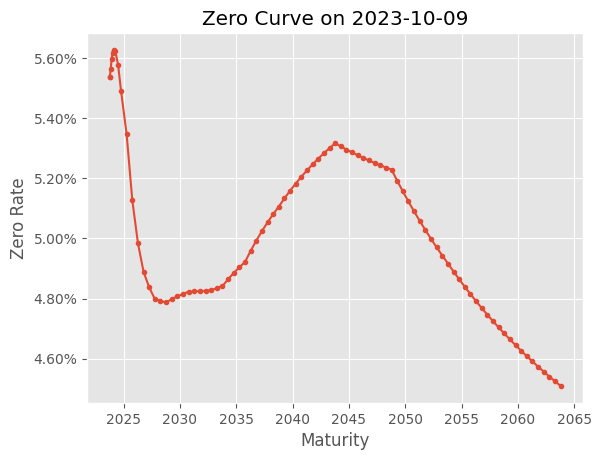

In [4]:
isplt.plot(x=discount_curve.dates,
     y=discount_curve.rates,
     title="Zero Curve on 2023-10-09",
     x_label="Maturity",
     y_label="Zero Rate",
     y_axis_formatter="percent",
     linestyle='-',
     marker='.')

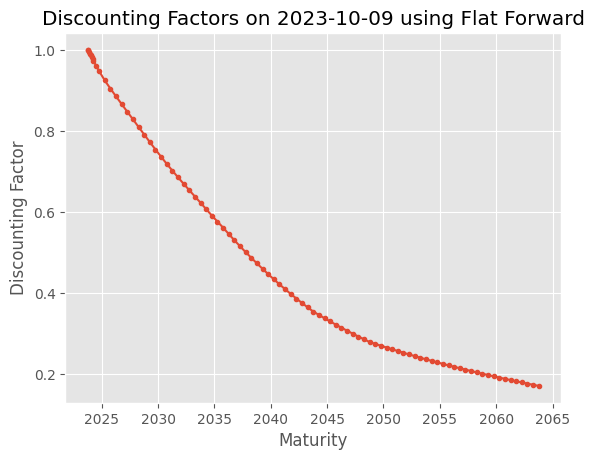

In [5]:
dfs = [ discount_curve.discount(date) for date in discount_curve.dates ]
isplt.plot(x=discount_curve.dates,
     y=dfs,
     title="Discounting Factors on 2023-10-09 using Flat Forward",
     x_label="Maturity",
     y_label="Discounting Factor",
     linestyle='-',
     marker='.')

## Bond Basis

Bond basis is the additional spread to add on top of the discount curve to match the marked price of the bond. Bond basis can be a large topic, and can be calibrated on top of discount curve, or on top of a survival curve. Here, we assume this spread is added on top of the discount curve. Two special cases are worth mentioning,

1. In absence of recovery and survival probability, the bond basis is the same as Z-spread.
2. Theoretically, a "perfect" recovery curve and survival curve should make the bond basis equal to zero, if all credit risks are priced in.

### Z-Spread

As mentioned, while calibrating Z-Spread, recovery rate and survival curve are not included, so we set them both to zeros. The `BondCurveAnalyticsHelper` creates a portfolio of bonds making easier to analyze the basket.

In [6]:
analyticsHelper = BondCurveAnalyticsHelper(bonds)
analyticsHelper.setup(
    settlement_dates=settlement_date,
    discount_curves=discount_curve,
    recovery_rates=0.,
    survival_curves=SurvivalCurveStep(anchor_date=valuation_date,
                                     dates = [valuation_date],
                                     hazard_rates=[0.],),
)
zspreads = analyticsHelper.get_bond_bases(
    valuation_date=valuation_date,
    dirty_prices=dirty_prices,
)

In [7]:
prettyTableByColumn(
    {
        'Numnber': range(1, len(bonds)+1),
        'Bond': bonds,
        'Z-Spread (bps)': (zspreads, '.4%')
    },
    align='llr'
)

+---------+-----------------+----------------+
| Numnber | Bond            | Z-Spread (bps) |
+---------+-----------------+----------------+
| 1       | 5.750% 03/01/24 |        0.2011% |
| 2       | 5.875% 02/15/25 |        0.5341% |
| 3       | 3.625% 06/15/25 |        0.7554% |
| 4       | 3.625% 06/15/25 |        0.7554% |
| 5       | 4.375% 11/15/26 |        0.8962% |
| 6       | 4.875% 04/15/28 |        1.0160% |
| 7       | 5.875% 11/15/28 |        1.0303% |
| 8       | 6.375% 05/15/29 |        1.0973% |
| 9       | 5.375% 11/15/29 |        1.2124% |
| 10      | 4.875% 06/15/30 |        1.2557% |
+---------+-----------------+----------------+


## Bond Issuer Curve: Nelson Siegel Svensson Form

The bond issuer curve, is essentially a survival curve calibrated from portfolio of bonds from the same issuer. When survival curve is constructed "perfectly", the model price of the bond should match the market price, as it shou reflect the credit risks of the issuer on any time horizon.

The Nelson Siegel Svensson form is a parametric form of the survival curve, and therefore can be calibrated.

The calibration of the bond issuer curve will search the best parameters for the NS curve that minimizes the overall unexplained error between the model price and the market price for the portfolio of bonds. Bond basis, in this case, is the "error" term.

In [8]:
# modify the recovery rate and survival curve for analyticsHelper
analyticsHelper.recovery_rates = 0.4
analyticsHelper.survival_curves = SurvivalCurveNelsonSiegel(
    anchor_date=valuation_date,
    pivot_dates=[datetime.date(2025, 6, 15), datetime.date(2029, 5, 15)],
)
analyticsHelper.valuation_date = valuation_date

# build the solver
bondCurveSolver = BondCurveSolver(bondAnalyticsHelper=analyticsHelper)

In [9]:
optimal_survival_params = bondCurveSolver.solve(
    dirty_prices=dirty_prices,
)
optimal_survival_params

array([ 9.22536681e-05, -6.83825154e-02,  5.67154784e-02])

Plug in the calibrated optimal parameters into the NS curve, and check the unexplained error (bond basis) for each bond. Below chart shows a very good fit, the bond bases are all close to zero and evenly distributed.

In [10]:
optimal_survival_curve = SurvivalCurveNelsonSiegel(
    anchor_date=valuation_date,
    pivot_dates=[datetime.date(2025, 6, 15), datetime.date(2029, 5, 15)],
    params=optimal_survival_params,
)
analyticsHelper.survival_curves = optimal_survival_curve
residuals = analyticsHelper.get_bond_bases(
    dirty_prices=dirty_prices,
)

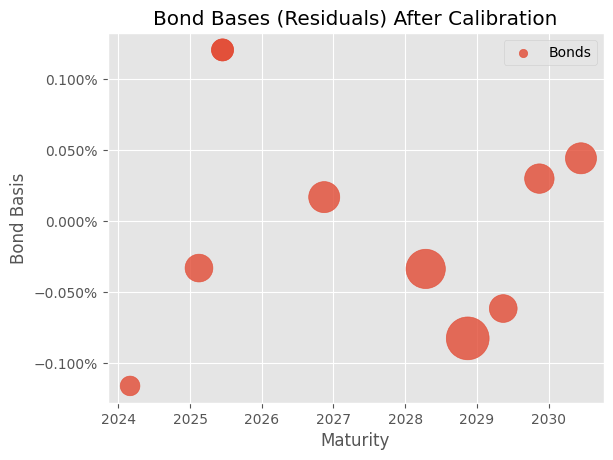

In [11]:
isplt.scatter(
    x = [x.maturity_date._date for x in bonds],
    y = residuals,
    y_axis_formatter="percent",
    title = "Bond Bases (Residuals) After Calibration",
    x_label = "Maturity",
    y_label = "Bond Basis",
    s = [ b / 2e6 for b in balance ],
    alpha = 0.8,
    label = "Bonds",
    legend = True,
)

## Bond Curve Par Spreads

With the calibrated continous survival curve, we can calculate the par spreads for sythetic CDSs with various maturities. And, ideally, these par spreads should be comparable to the CDS par spreads on the market.

In [12]:
tenors = ["3m", "6m", "9m", "1y", "18m", "2y", "3y", "4y", "5y", "7y", "10y", "15y", "20y", "30y"]
expiries = [Date(2023, 12, 20).add_tenor(tenor)._date for tenor in tenors]

par_spreads = cds_market_spreads(
    discount_curve=discount_curve,
    survival_curve=optimal_survival_curve,
    recovery_rate=0.4,
    expiries=expiries,
    cds_style="CORP_NA",
    granularity=14,
)

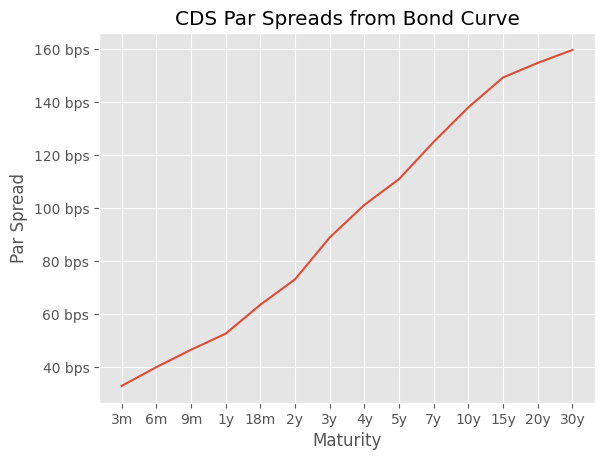

In [13]:
isplt.plot(
    x = tenors,
    y = par_spreads,
    title = "CDS Par Spreads from Bond Curve",
    x_label = "Maturity",
    y_label = "Par Spread",
    y_axis_formatter="bps",
    x_tick_labels = tenors,
)